In [17]:
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()

In [19]:
def giniImpurity(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return np.sum(ps * (1 - ps))

In [20]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [21]:
def bootstrap_sample(X, y):
    num_samples = X.shape[0]
    indexes = np.random.choice(num_samples, num_samples, replace=True)
    return X[indexes], y[indexes]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [22]:
class DecisionTree(BaseEstimator):
  def __init__(self, min_num_samples_split=5, max_tree_depth=100, num_features=None):
    self.min_num_samples_split = min_num_samples_split
    self.max_tree_depth = max_tree_depth
    self.num_features = num_features
    self.root = None

  def fit(self, X, y):
    self.num_features = X.shape[1] if not self.num_features else min(self.num_features, X.shape[1])
    self.root = self.grow_tree(X, y)

  def grow_tree(self, X, y, depth=0):
    num_samples, num_features = X.shape
    num_labels = len(np.unique(y))

    # Stopping criteria
    if (depth >= self.max_tree_depth or num_labels == 1 or num_samples < self.min_num_samples_split):
      leaf_value = most_common_label(y)
      return Node(value=leaf_value)

    feature_indexes = np.random.choice(num_features, self.num_features, replace=False)

    best_feature, best_threshold = self.get_best_split(X, y, feature_indexes)

    # Grow the tree from the split
    left_idxs, right_idxs = self.split(X[:, best_feature], best_threshold)
    left = self.grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
    right = self.grow_tree(X[right_idxs, :], y[right_idxs], depth+1)

    return Node(best_feature, best_threshold, left, right)

  def get_best_split(self, X, y, feature_indexes):
    best_gini_gain = -1
    split_index, split_threshold = None, None
    for feature_index in feature_indexes:
      X_column = X[:, feature_index]
      thresholds = np.unique(X_column)
      for threshold in thresholds:
        gain = self.gini_gain(y, X_column, threshold)

        if gain > best_gini_gain:
          best_gini_gain = gain
          split_index = feature_index
          split_threshold = threshold

    return split_index, split_threshold

  def gini_gain(self, y, X_column, split_threshold):
    # parent
    parent_gini_impurity = giniImpurity(y)

    # generate split
    left_idxs, right_idxs = self.split(X_column, split_threshold)

    if len(left_idxs) == 0 or len(right_idxs) == 0:
        return 0

    # compute the weighted average for the children
    n = len(y)
    num_left, num_right = len(left_idxs), len(right_idxs)
    gini_left, gini_right = giniImpurity(y[left_idxs]), giniImpurity(y[right_idxs])
    child_gini_impurity = (num_left / n) * gini_left + (num_right / n) * gini_right

    # gini gain is difference in loss before vs. after split
    gini_gain = parent_gini_impurity - child_gini_impurity
    return gini_gain

  def split(self, X_column, split_threshold):
    left_idxs = np.argwhere(X_column <= split_threshold).flatten()
    right_idxs = np.argwhere(X_column > split_threshold).flatten()
    return left_idxs, right_idxs

  def predict(self, X):
    return np.array([self.traverse_tree(x, self.root) for x in X])

  def traverse_tree(self, x, node):
    if node.is_leaf_node():
        return node.value

    if x[node.feature] <= node.threshold:
        return self.traverse_tree(x, node.left)
    return self.traverse_tree(x, node.right)

In [32]:
class RandomForest(BaseEstimator):
    def __init__(self, num_trees=10, min_num_samples_split=5,
                 max_tree_depth=10, num_features=None):
        self.num_trees = num_trees
        self.min_num_samples_split = min_num_samples_split
        self.max_tree_depth = max_tree_depth
        self.num_features = num_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.num_trees):
            tree = DecisionTree(min_num_samples_split=self.min_num_samples_split,
                                max_tree_depth=self.max_tree_depth,
                                num_features=self.num_features)
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_predictions = np.swapaxes(tree_predictions, 0, 1)
        y_pred = [most_common_label(tree_prediction) for tree_prediction in tree_predictions]
        return np.array(y_pred)

In [24]:
# Mount Google drive and copy kaggle.json to local disk

from google.colab import drive
drive.mount('mount')

!cp mount/MyDrive/kaggle.json .

Drive already mounted at mount; to attempt to forcibly remount, call drive.mount("mount", force_remount=True).


In [25]:
!KAGGLE_CONFIG_DIR=$(pwd) kaggle datasets download rabieelkharoua/students-performance-dataset

Dataset URL: https://www.kaggle.com/datasets/rabieelkharoua/students-performance-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
students-performance-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [26]:
!unzip -o students-performance-dataset.zip -d students-performance-dataset

Archive:  students-performance-dataset.zip
  inflating: students-performance-dataset/Student_performance_data _.csv  


In [27]:
student_performance_df_orig = pd.read_csv('students-performance-dataset/Student_performance_data _.csv')

In [28]:
student_performance_df = student_performance_df_orig.drop(['StudentID', 'GradeClass', 'GPA'], axis=1)
student_performance_df = pd.DataFrame(standard_scaler.fit_transform(student_performance_df), columns=student_performance_df.columns)
student_performance_df

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
0,0.472919,0.978492,-0.853391,0.253711,1.780336,-0.890822,1.522371,-0.108744,-0.788476,-0.660132,2.019544,-0.431866
1,1.362944,-1.021981,-0.853391,-0.746087,0.997376,-1.717694,-0.656870,-0.999551,-0.788476,-0.660132,-0.495161,-0.431866
2,-1.307132,-1.021981,1.091641,1.253509,-0.984045,1.353542,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,-0.431866
3,0.472919,0.978492,-0.853391,1.253509,0.045445,-0.063951,-0.656870,0.782063,1.268269,-0.660132,-0.495161,-0.431866
4,0.472919,0.978492,-0.853391,0.253711,-0.902311,0.290422,1.522371,0.782063,-0.788476,-0.660132,-0.495161,-0.431866
...,...,...,...,...,...,...,...,...,...,...,...,...
2387,1.362944,0.978492,-0.853391,1.253509,0.160762,-1.481445,-0.656870,1.672869,1.268269,-0.660132,-0.495161,-0.431866
2388,0.472919,-1.021981,-0.853391,-0.746087,-0.387285,-1.245196,1.522371,1.672869,-0.788476,1.514848,-0.495161,-0.431866
2389,-0.417106,0.978492,-0.853391,0.253711,-0.524895,0.644796,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,2.315535
2390,-0.417106,0.978492,0.119125,-1.745885,0.467950,0.290422,-0.656870,-0.108744,-0.788476,1.514848,2.019544,-0.431866


In [29]:
student_performance_target = np.array(student_performance_df_orig['GradeClass'].map(lambda gradeclass: 0 if gradeclass <= 3.0 else 1), dtype=np.int8)
student_performance_target

array([0, 0, 1, ..., 0, 0, 0], dtype=int8)

In [33]:
from sklearn.model_selection import cross_val_score

random_forest = RandomForest(num_trees=11, max_tree_depth=11, num_features=6)

cross_val_score(random_forest, student_performance_df.values, student_performance_target, cv=2, scoring='accuracy')

array([0.90551839, 0.85033445])

In [34]:
from sklearn.model_selection import cross_val_predict

student_performance_predicted_target = cross_val_predict(random_forest, student_performance_df.values, student_performance_target, cv=2)

In [35]:
from sklearn.metrics import confusion_matrix

In [36]:
confusion_matrix(student_performance_target, student_performance_predicted_target)

array([[1025,  156],
       [ 112, 1099]])

In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8884344104800813

In [38]:
recall_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8879598662207357

In [39]:
f1_score(student_performance_target, student_performance_predicted_target, average='weighted')

0.8878960469979277

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(student_performance_target, student_performance_predicted_target)

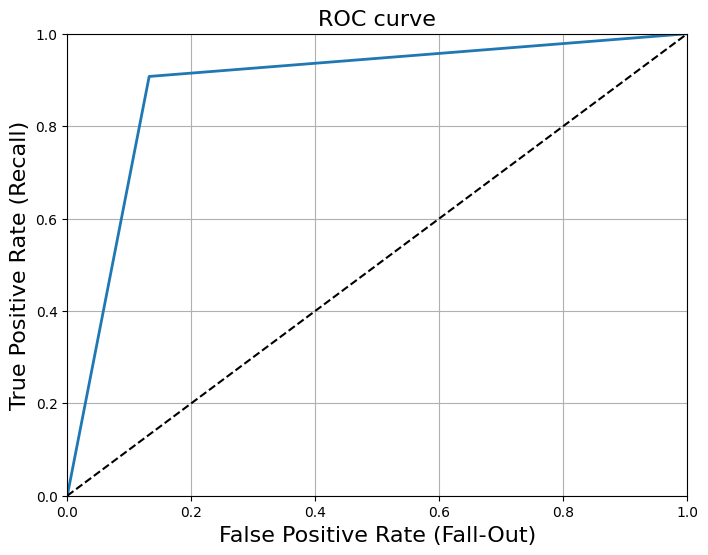

In [41]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.title("ROC curve", fontsize=16)
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score

roc_auc_score(student_performance_target, student_performance_predicted_target)

0.8877115014707826